**Лабораторная работа 1**

Выполнил Баулкин Данир М8О-312Б-23

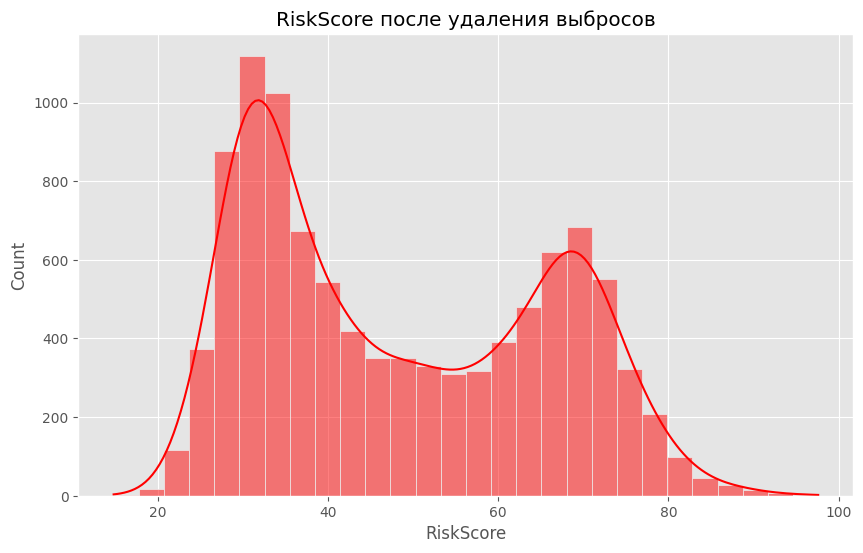

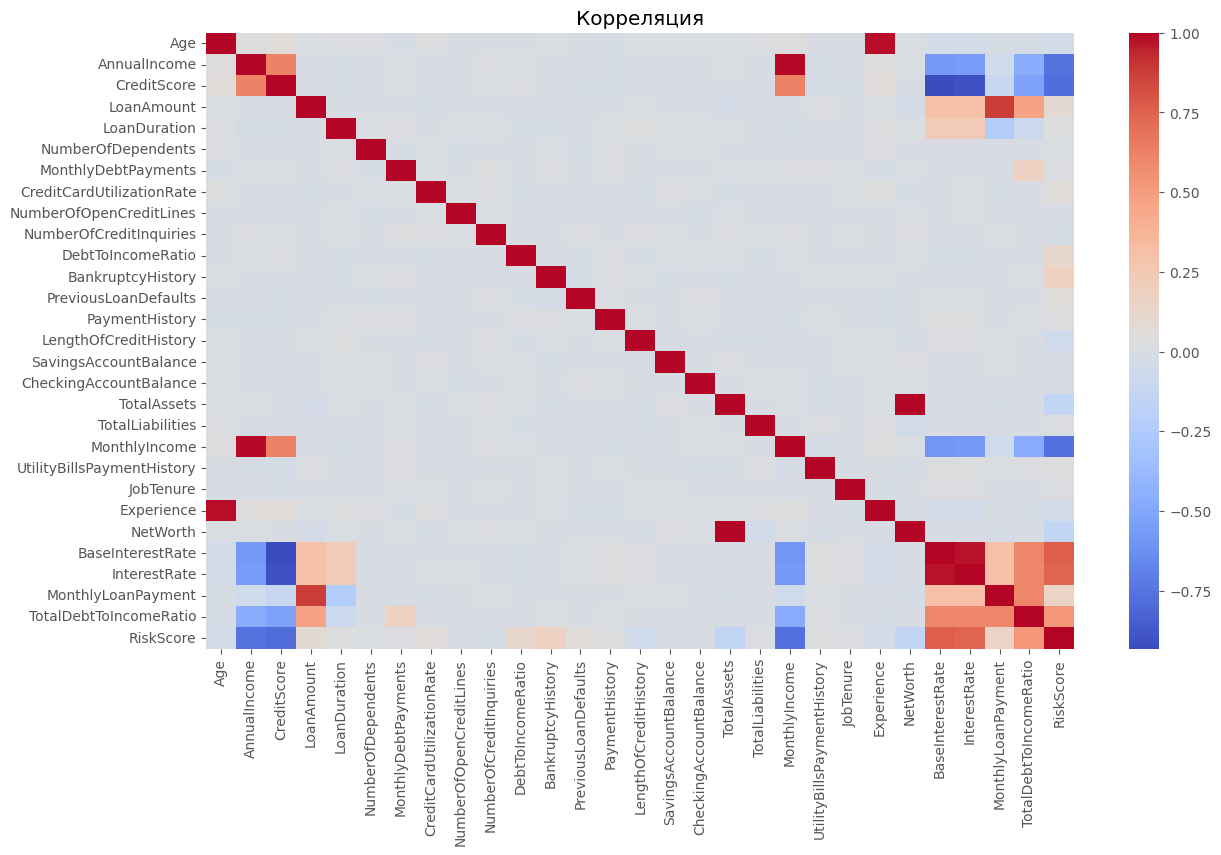

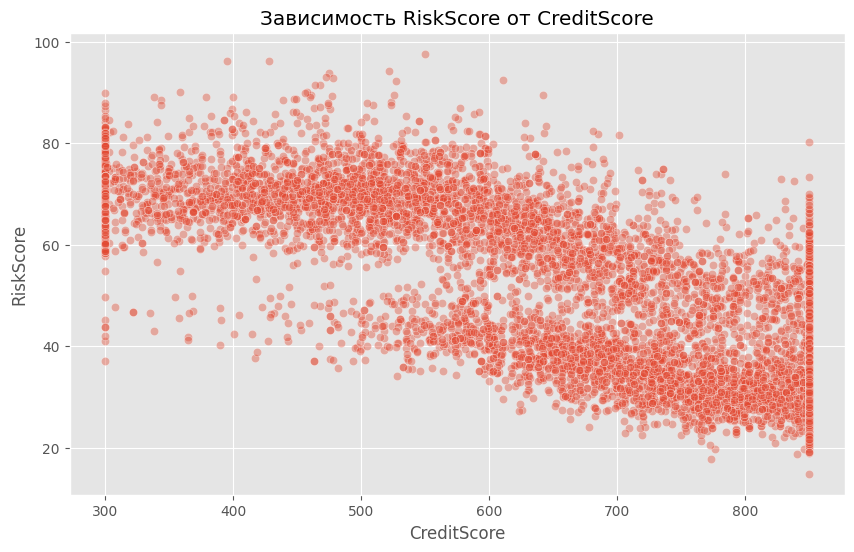

LOO MSE: 180.7395
MSE на train: 24.9050
Analytic MSE: 24.8635
GD MSE: 1618.5787
SGD MSE: 2635.7786

Аналитическое решение самое точное, а GD и SGD требуют правильного подбора гиперпараметров
MSE 24.9050, Sklearn=24.9050
MAE 3.7404, Sklearn=3.7404
R2 0.9162, Sklearn=0.9162
MAPE 8.6109, Sklearn=8.6109


In [40]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
warnings.filterwarnings("ignore")

ex_dataset = 'ex.csv'
train_dataset = 'train.csv'
test_dataset = 'test.csv'
train_df  = pd.read_csv(train_dataset)
test_df  = pd.read_csv(test_dataset)

train_df = train_df[(train_df['RiskScore'] > 0) & (train_df['RiskScore'] < 1000)].dropna(subset=['RiskScore'])

plt.figure(figsize=(10, 6))
sns.histplot(train_df['RiskScore'], kde=True, color='red')
plt.title('RiskScore после удаления выбросов')
plt.show()

numeric_df = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(14, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title('Корреляция')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='CreditScore', y='RiskScore', alpha=0.4)
plt.title('Зависимость RiskScore от CreditScore')
plt.show()


class myScaler:
    def __init__(self):
        self.mean = None
        self.std = None
    def fit(self, data):
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0) + 1e-8
    def transform(self, data):
        return (data - self.mean) / self.std
    def z_score(self, data):
        return (data - data.mean()) / (data.std() + 1e-8)
    def min_max(self, data):
        return (data - data.min()) / (data.max() - data.min() + 1e-8)

def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
def manual_k_fold(X, y, k=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)
    
    cv_scores = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
        model_cv = MyLinearRegression(method='analytic', lambda_reg=0.01)
        model_cv.fit(X[train_idx], y[train_idx])
        preds_cv = model_cv.predict(X[val_idx])
        score = manual_mse(y[val_idx], preds_cv)
        cv_scores.append(score)
        print(f"Fold {i+1} MSE: {score:.4f}")
        
    print(f"Average K-Fold MSE: {np.mean(cv_scores):.4f}")
class MyLinearRegression:
    def __init__(self, method='analytic', lr=0.001, epochs=1000, 
                 reg_type=None, lambda_reg=0.1, p=2):
        self.method = method
        self.lr = lr
        self.epochs = epochs
        self.reg_type = reg_type 
        self.lambda_reg = lambda_reg
        self.p = p 
        self.w = None

    def _add_bias(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def _get_reg_grad(self, w):
        if self.reg_type == 'L1':
            return self.lambda_reg * np.sign(w)
        elif self.reg_type == 'L2':
            return self.lambda_reg * 2 * w
        elif self.reg_type == 'Elastic':
            return self.lambda_reg * (np.sign(w) + 2 * w)
        elif self.reg_type == 'Lp':
            return self.lambda_reg * self.p * (np.abs(w)**(self.p-1)) * np.sign(w)
        return 0

    def fit(self, X, y):
        X = self._add_bias(X)
        n_features = X.shape[1]
        
        if self.method == 'analytic':
            I = np.eye(n_features)
            I[0, 0] = 0 
            self.w = np.linalg.inv(X.T @ X + (self.lambda_reg + 1e-6) * I) @ X.T @ y
            
        elif self.method in ['gd', 'sgd']:
            self.w = np.zeros(n_features)
            for _ in range(self.epochs):
                if self.method == 'gd':
                    y_pred = X @ self.w
                    grad = (2/len(X)) * (X.T @ (y_pred - y)) + self._get_reg_grad(self.w)
                    self.w -= self.lr * grad
                else: 
                    idx = np.random.randint(len(X))
                    xi = X[idx:idx+1]
                    yi = y[idx:idx+1]
                    grad = 2 * (xi.T @ (xi @ self.w - yi)) + self._get_reg_grad(self.w)
                    self.w -= self.lr * grad

    def predict(self, X):
        X = self._add_bias(X)
        return X @ self.w
def manual_loo_cv(X, y, n_samples=50):
    X_small = X[:n_samples]
    y_small = y[:n_samples]
    errors = []
    
    for i in range(n_samples):
        X_train = np.delete(X_small, i, axis=0)
        y_train = np.delete(y_small, i)
        X_val = X_small[i].reshape(1, -1)
        y_val = y_small[i]
        
        model = MyLinearRegression(method='analytic', lambda_reg=0.01)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        errors.append((y_val - pred[0])**2)
        
    print(f"LOO MSE: {np.mean(errors):.4f}")

manual_loo_cv(X_train_scaled, y_final, n_samples=50)
def prepare_data(df, is_train=True, top_features_list=None):
    df = df.copy()
    
    if 'ApplicationDate' in df.columns:
        dt = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['App_Year'] = dt.dt.year.fillna(2024)
        df = df.drop(['ApplicationDate'], axis=1)
    if 'ID' in df.columns:
        df = df.drop(['ID'], axis=1)

    if 'EducationLevel' in df:
        edu_map = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
        df['Edu_Rank'] = df['EducationLevel'].map(edu_map).fillna(0)
    
    eps = 1e-10
    if 'InterestRate' in df and 'BaseInterestRate' in df:
        df['Rate_Spread'] = df['InterestRate'] - df['BaseInterestRate']
    
    df["DTI_Total"] = (df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"].fillna(0)) / (df["MonthlyIncome"] + eps)
    df["Loan_to_Inc"] = df["LoanAmount"] / (df["AnnualIncome"] + eps)
    df["Debt_to_Assets"] = df["TotalLiabilities"] / (df["TotalAssets"] + eps)
    
    if 'CreditScore' in df:
        df['CS_Bins'] = pd.qcut(df['CreditScore'], 10, labels=False, duplicates='drop').fillna(0)

    if is_train:
        temp_df = df.select_dtypes(include=[np.number]).fillna(0)
        corrs = temp_df.corrwith(pd.Series(y_final, index=temp_df.index)).abs().sort_values(ascending=False)
        top_features_list = corrs.index[:22].tolist()
    
    for i in range(len(top_features_list)):
        c1 = top_features_list[i]
        if c1 in df.columns:
            df[f'{c1}_sq'] = df[c1]**2 
            if i < 7: df[f'{c1}_cube'] = df[c1]**3
            for j in range(i + 1, len(top_features_list)):
                c2 = top_features_list[j]
                if c2 in df.columns:
                    df[f'v_{c1}_{c2}'] = df[c1] * df[c2] 

    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
            if df[col].nunique() > 10:
                low, high = df[col].quantile([0.012, 0.993])
                df[col] = df[col].clip(low, high)
            
    df = pd.get_dummies(df, drop_first=True)
    return df, top_features_list

train_df = pd.read_csv(train_dataset)
train_df = train_df.dropna(subset=['RiskScore'])

train_df = train_df[train_df["RiskScore"].between(0, 100)]

q_1 = train_df['RiskScore'].quantile(0.25)
q_2 = train_df['RiskScore'].quantile(0.75)
train_df = train_df[~((train_df['RiskScore'] > (q_2 + 1.9 * (q_2 - q_1))) | (train_df['RiskScore'] < (q_1 - 1.9 * (q_2 - q_1))))]

y_final = train_df['RiskScore'].values 

X_train_p, sel_top = prepare_data(train_df.drop('RiskScore', axis=1), is_train=True)
X_test_p, _ = prepare_data(test_df, is_train=False, top_features_list=sel_top)

X_train, X_test = X_train_p.align(X_test_p, join='left', axis=1, fill_value=0)

scaler = myScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train).values
X_test_scaled = scaler.transform(X_test).values
final_model = MyLinearRegression(method='analytic', lambda_reg=0.4) 
final_model.fit(X_train_scaled, y_final)
train_preds = final_model.predict(X_train_scaled)
print(f"MSE на train: {custom_mse(y_final, train_preds):.4f}")

test_predictions = final_model.predict(X_test_scaled)
test_predictions = np.clip(test_predictions, 0, 100)

submission = pd.DataFrame({
    'ID': pd.read_csv(test_dataset)['ID'],
    'RiskScore': test_predictions})
submission.to_csv('submission.csv', index=False)

model_an = MyLinearRegression(method='analytic', lambda_reg=0.01)
model_an.fit(X_train_scaled, y_final)
mse_an = custom_mse(y_final, model_an.predict(X_train_scaled))
print(f"Analytic MSE: {mse_an:.4f}")

model_gd = MyLinearRegression(method='gd', lr=0.0001, epochs=1000, lambda_reg=0.01)
model_gd.fit(X_train_scaled, y_final)
mse_gd = custom_mse(y_final, model_gd.predict(X_train_scaled))
print(f"GD MSE: {mse_gd:.4f}")

model_sgd = MyLinearRegression(method='sgd', lr=0.0000001, epochs=10, lambda_reg=0.01)
model_sgd.fit(X_train_scaled, y_final)
mse_sgd = custom_mse(y_final, model_sgd.predict(X_train_scaled))
print(f"SGD MSE: {mse_sgd:.4f}")
print("\nАналитическое решение самое точное, а GD и SGD требуют правильного подбора гиперпараметров")
print(f"MSE {custom_mse(y_final, train_preds):.4f}, Sklearn={mean_squared_error(y_final, train_preds):.4f}")
print(f"MAE {custom_mae(y_final, train_preds):.4f}, Sklearn={mean_absolute_error(y_final, train_preds):.4f}")
print(f"R2 {custom_r2(y_final, train_preds):.4f}, Sklearn={r2_score(y_final, train_preds):.4f}")
print(f"MAPE {custom_mape(y_final, train_preds):.4f}, Sklearn={mean_absolute_percentage_error(y_final, train_preds)*100:.4f}")

 